In [52]:
import numpy as np
import sys,math
sys.path.append('../../../programs/extractdropletdata/')
import millidrop_dataclass as mdc
import os,glob
#import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib

from scipy.optimize import curve_fit

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12,8]
matplotlib.rc('font',family='Monospace')

In [30]:
dropfiles = glob.glob('droplets/*.csv')
templatefile = 'template.csv'

# fluo_1_mean: PVD
# fluo_2_mean: mCherry
# fluo_3_mean: GFP
# fluo_4_mean: YFP

kwargs = {'infiles':dropfiles,'templatefile':templatefile,'datacolumns':['time','fluo_2_mean','fluo_1_mean']}

data = mdc.DropletData(**kwargs)
data.set_restriction('max','all',['time',130000])

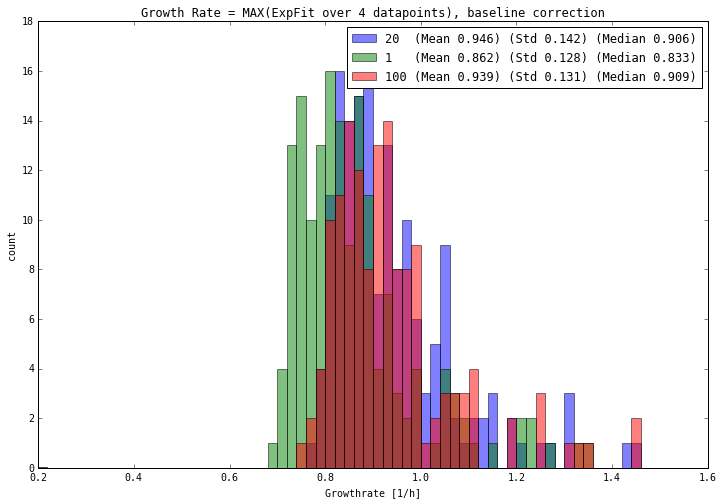

In [71]:
number_points = 4
lgnd = list()
for label,trajectories in data:
    if label in allowedlabels: #label.upper() != 'SEPARATOR':
        gr = list()
        y = list()
        for t in trajectories:
            t[:,0] /= 3.6e3
            t[:,1] = np.abs(t[:,1]  + 1.49028579754e-07*3.6e3*t[:,0] - 0.0873583211834)
            
            grt = np.array([(number_points * np.sum(t[i:i+number_points,0] * np.log(t[i:i+number_points,1])) - np.sum(t[i:i+number_points,0])*np.sum(np.log(t[i:i+number_points,1]))) / \
                            (number_points * np.sum(t[i:i+number_points,0] * t[i:i+number_points,0])         - np.sum(t[i:i+number_points,0])*np.sum(t[i:i+number_points,0])) for i in range(len(t[:,0]-number_points))])
            
            
            gr.append(np.max(grt))
            y.append(np.max(t[:,1]))
            
        plt.hist(gr,range=(0.2,1.5),bins=65,alpha=.5)
        plt.xlabel('Growthrate [1/h]')
        plt.ylabel('count')
        lgnd.append('{:3s} (Mean {:.3f}) (Std {:.3f}) (Median {:.3f})'.format(label,np.mean(gr),np.std(gr),np.median(gr)))
plt.title('Growth Rate = MAX(ExpFit over 4 datapoints), baseline correction')

plt.legend(lgnd)
plt.show()
    

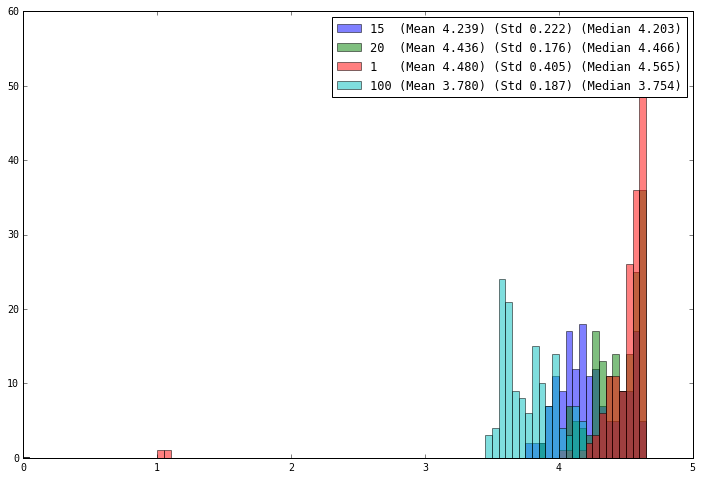

In [28]:
allowedlabels = ['1','15','20','100']

lgnd = list()

for label,trajectories in data:
    if label in allowedlabels:
        y = list()
        for t in trajectories:
            y.append(np.max(t[:,1]))
        
        
        plt.hist(y,range=(0,5),bins=100,alpha=.5)
        lgnd.append('{:3s} (Mean {:.3f}) (Std {:.3f}) (Median {:.3f})'.format(label,np.mean(y),np.std(y),np.median(y)))
plt.legend(lgnd)
plt.show()

In [51]:
def logisticfunction(x,gr,t0,mx):
    return mx/(1+np.exp(-gr*(x-t0)))

-1.49028579754e-07 0.0873583211834


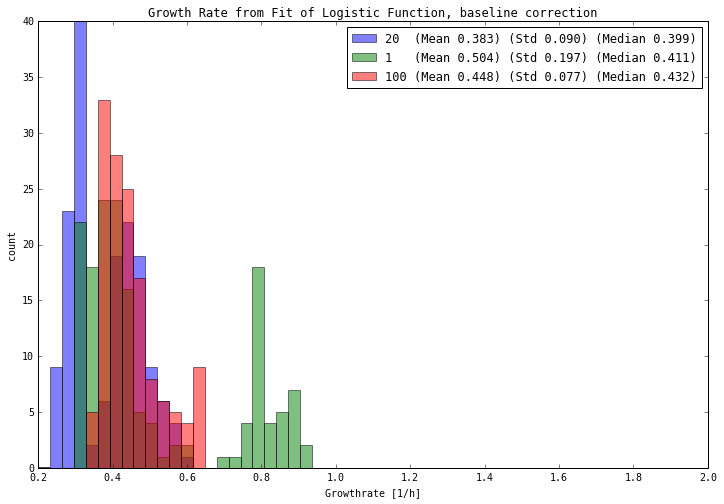

In [73]:
baseline_maxtime = 45000
maxfev = 5000
baseline_t = np.array([])
baseline_s = np.array([])

allowedlabels = ['1','20','100']

for label,tr in data:
    if label in allowedlabels:
        for t in tr:
            tm  = t[:,0]
            pmt = t[:,1]
            baseline_t = np.concatenate([baseline_t,tm[tm<baseline_maxtime]])
            baseline_s = np.concatenate([baseline_s,pmt[tm<baseline_maxtime]])

            
a = (len(baseline_t) * np.sum(baseline_t * baseline_s) - np.sum(baseline_t) * np.sum(baseline_s)) / (len(baseline_t) * np.sum(baseline_t*baseline_t) - np.sum(baseline_t) * np.sum(baseline_t))
b = (np.sum(baseline_s) - a * np.sum(baseline_t))/len(baseline_t)

print a,b

#a=b=0

number_points = 4
lgnd = list()
for label,tr in data:
    if label in allowedlabels:
        gr = list()
        lgr = list()
        for t in tr:
            tm  = t[:,0]
            sg  = t[:,1]

            sg  = sg[tm>baseline_maxtime]
            tm  = tm[tm>baseline_maxtime]
            #print tm
            
            sg  = np.abs(sg - a * tm - b)
            tm /= 3.6e3
            
            p0 = np.array([1,20,5])
            try:
                fit,cov = curve_fit(logisticfunction,tm,sg,p0=p0,maxfev = maxfev)
            except:
                fit = np.zeros(3)
            #print fit[0]
            
            #plt.semilogy(tm,sg)
            
            grt = np.array([(number_points * np.sum(tm[i:i+number_points] * np.log(sg[i:i+number_points])) - np.sum(tm[i:i+number_points])*np.sum(np.log(sg[i:i+number_points]))) / \
                            (number_points * np.sum(tm[i:i+number_points] * tm[i:i+number_points])         - np.sum(tm[i:i+number_points])*np.sum(tm[i:i+number_points])) for i in range(len(tm)-number_points)])
            
            
            #plt.plot(tm[:-number_points],grt)
            
            gr.append(np.max(grt))
            lgr.append(fit[0])
        #plt.show()
        plt.hist(lgr,range=(.2,1.8),bins=50,alpha=.5)
        plt.xlabel('Growthrate [1/h]')
        plt.ylabel('count')
        lgnd.append('{:3s} (Mean {:.3f}) (Std {:.3f}) (Median {:.3f})'.format(label,np.mean(lgr),np.std(lgr),np.median(lgr)))
plt.title('Growth Rate from Fit of Logistic Function, baseline correction')
plt.legend(lgnd)
plt.show()



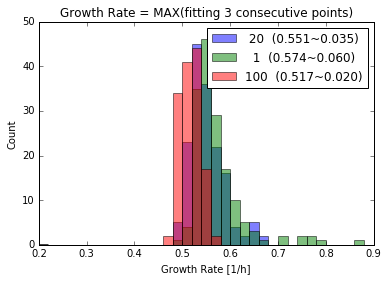

In [76]:
number_points = 3
lgnd = list()
plt.title('Growth Rate = MAX(fitting 3 consecutive points)')
for label,trajectories in data:
    if label == '1' or label == '100' or label == '20': #label.upper() != 'SEPARATOR':
        gr = list()
        y = list()
        for t in trajectories:
            t[:,0] /= 3.6e3
            grt = np.array([(number_points * np.sum(t[i:i+number_points,0] * np.log(t[i:i+number_points,1])) - np.sum(t[i:i+number_points,0])*np.sum(np.log(t[i:i+number_points,1]))) / \
                            (number_points * np.sum(t[i:i+number_points,0] * t[i:i+number_points,0])         - np.sum(t[i:i+number_points,0])*np.sum(t[i:i+number_points,0])) for i in range(len(t[:,0]-number_points))])
            
            
            gr.append(np.max(grt))
            y.append(np.max(t[:,1]))
            
        plt.hist(gr,range=(0.2,.9),bins=35,alpha=.5)
        plt.xlabel('Growth Rate [1/h]')
        plt.ylabel('Count')
        lgnd.append('{:3d}  ({:.3f}~{:.3f})'.format(int(label),np.mean(gr),np.std(gr)))
plt.legend(lgnd)
plt.show()
    

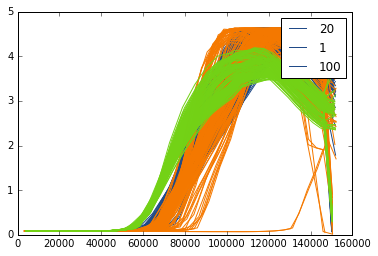

In [80]:
c = {'1':'#f57900','5':'#ef2929','10':'#a40000','15':'#729fcf','20':'#204a87','100':'#73d216'}
acceptedlabels = ['1','20','100']

lgnd = list()

for label,trajectories in data:
    if label in acceptedlabels:
        for t in trajectories:
            plt.plot(t[:,0],t[:,1],color = c[label])
        lgnd.append(label)
plt.legend(lgnd)
plt.show()

In [112]:
dropfiles = glob.glob('/home/lukas/projects/millifluidics/experimentaldata/maxime2017/2017-06-28_inoculum/droplets/*.csv')
templatefile = '/home/lukas/projects/millifluidics/experimentaldata/maxime2017/2017-06-28_inoculum/template.csv'

# fluo_1_mean: PVD
# fluo_2_mean: mCherry
# fluo_3_mean: GFP
# fluo_4_mean: YFP

kwargs = {'infiles':dropfiles,'templatefile':templatefile,'datacolumns':['time','fluo_2_mean','fluo_1_mean'],'SplitBackForthTrajectories':False}

dataJune = mdc.DropletData(**kwargs)
dataJune.set_restriction('max',None,['time',25*3600])

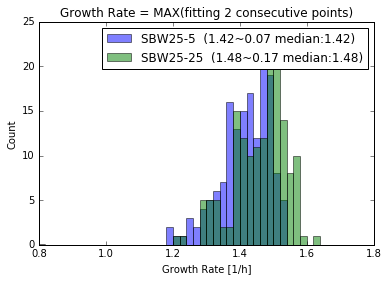

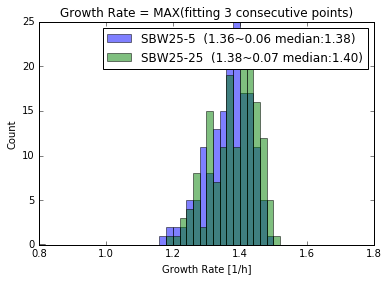

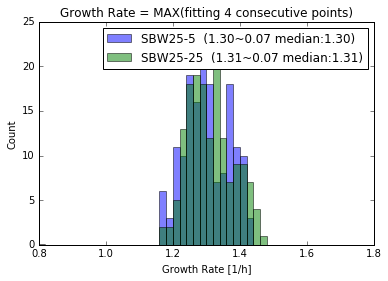

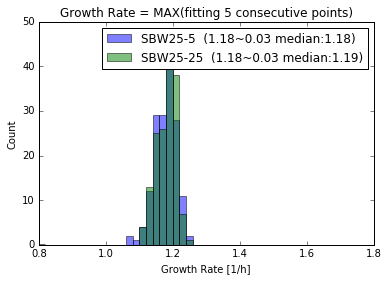

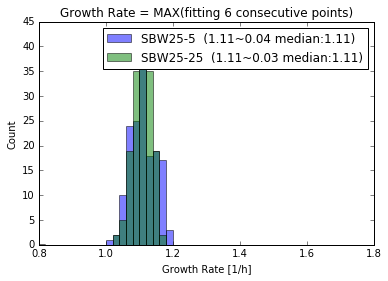

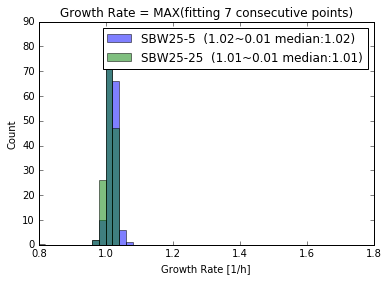

In [113]:
for number_points in range(2,8):
    lgnd = list()
    plt.title('Growth Rate = MAX(fitting {:d} consecutive points)'.format(number_points))
    for label,trajectories in dataJune:
        if label != 'KB' and label != 'Empty':
            gr = list()
            y = list()
            for t in trajectories:
                t[:,0] /= 3.6e3
                grt = np.array([(number_points * np.sum(t[i:i+number_points,0] * np.log(t[i:i+number_points,1])) - np.sum(t[i:i+number_points,0])*np.sum(np.log(t[i:i+number_points,1]))) / \
                                (number_points * np.sum(t[i:i+number_points,0] * t[i:i+number_points,0])         - np.sum(t[i:i+number_points,0])*np.sum(t[i:i+number_points,0])) for i in range(len(t[:,0]-number_points))])


                gr.append(np.max(grt))
                y.append(np.max(t[:,1]))

            plt.hist(gr,range=(.8,1.8),bins=50,alpha=.5)
            plt.xlabel('Growth Rate [1/h]')
            plt.ylabel('Count')
            lgnd.append('{:s}  ({:.2f}~{:.2f} median:{:.2f})'.format(label,np.mean(gr),np.std(gr),np.median(gr)))
    plt.legend(lgnd)
    plt.show()